In [1]:
import pandas
import feather
import datetime
import numpy
from scipy.optimize import curve_fit
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
from davitpy.models import *
from davitpy import utils
from aacgmv2 import convert_mlt
%matplotlib inline

In [2]:
sizeAsyCutoff = 50.

In [3]:
potDF = feather.read_dataframe('../data/potDF.feather')
# There are too many Asy values, to model 
# we'll round it off to nearest 40. This
# is equivalent to binning.
# Get number of values for different Asy Inds
# discard those values which have low counts
sizeAsyDF = potDF.groupby("AsyH").size().reset_index()
sizeAsyDF.columns = [ "AsyH", "asyCnt" ]
sizeAsyDF = sizeAsyDF[ sizeAsyDF["asyCnt"] >= sizeAsyCutoff]
potDF = pandas.merge(potDF, sizeAsyDF,\
                     on = "AsyH", how="inner"\
                    ).reset_index(drop=True)
potDF["AsyHRnd"] = numpy.round(potDF["AsyH"]/40.)*40.
# Get peak potentials
peakPotDF = potDF[[ "AsyH", "potMagn" ]].groupby( "AsyH" ).max().reset_index()
peakPotDF.columns = [ "AsyH", "peakPotMagn" ]
# Normalize the values of potential
# for every AsyH value. This makes 
# fitting easy!
potDF = pandas.merge( potDF, peakPotDF, on="AsyH" )
potDF["normPot"] = potDF["potMagn"]/potDF["peakPotMagn"]
potDF.head()

,AsyH,MLAT,normMLT,potential,normLAT,potMagn,mlt,asyCnt,AsyHRnd,peakPotMagn,normPot
0,45.0,56.5,-7.0,-2.21,-2.0,2.21,17.0,186,40.0,34.55,0.063965
1,45.0,57.0,-7.0,-3.82,-1.5,3.82,17.0,186,40.0,34.55,0.110564
2,45.0,57.5,-7.0,-5.75,-1.0,5.75,17.0,186,40.0,34.55,0.166425
3,45.0,58.5,-7.0,-7.77,0.0,7.77,17.0,186,40.0,34.55,0.224891
4,45.0,59.0,-7.0,-10.10,0.5,10.10,17.0,186,40.0,34.55,0.292330


In [4]:
mlatMLTPotDF = potDF[ ["AsyHRnd", "normMLT", "normPot", "MLAT"]\
                ].groupby( ["AsyHRnd", "normMLT", "MLAT"] \
                ).mean().reset_index()
mlatMLTPotDF.head()
mlatMLTPotDF["testMLAT"] = numpy.abs( mlatMLTPotDF["MLAT"] - mlatMLTPotDF["MLAT"].max() )

In [5]:
# To estimate MLAT variations we
# fit a polynomial function!
def mlat_mlt_fit_func((mlat, normMLT, asy),\
            c0_a, c0_b, c0_c, c1_a, c1_b, c1_c, c2):
    c0 = c0_a + c0_b * asy + c0_c*normMLT
    c1 = c1_a + c1_b * asy + c1_c*normMLT
    return c0 + c1*mlat + c2*numpy.square(mlat)

# def mlat_mlt_fit_func((mlat, normMLT, asy),\
#             c0_a, c0_b, c0_c, c1, c2):
#     c0 = c0_a + c0_b * asy + c0_c*normMLT
# #     c1 = c1_a + c1_b * asy + c1_c*normMLT
# #     c2 = c2_a + c2_b * asy + c2_c*normMLT
#     return c0 + c1*numpy.exp( mlat*c2 )

In [6]:
poptMlatMLTPot, pcovMlatMLTPot = curve_fit(mlat_mlt_fit_func,\
                               (mlatMLTPotDF['MLAT'].T,\
                                mlatMLTPotDF['normMLT'].T, mlatMLTPotDF['AsyHRnd'].T),\
                               mlatMLTPotDF['normPot'], p0=(1., 1., 1., 1., 1., 1., 1.))
poptMlatMLTPot = [ round(x,5) for x in poptMlatMLTPot ]
print poptMlatMLTPot

predAsyArr = []
predMlatArr = []
predPotArr = []
predNormMltArr = []

for currAsy in mlatMLTPotDF["AsyHRnd"].unique():
    for currNMLT in mlatMLTPotDF["normMLT"].unique():
        for cpMlat in range(53,65,1):
            predMlatArr.append( cpMlat )
            predAsyArr.append( currAsy )
            predNormMltArr.append( currNMLT )
            # Fit params
            predPotArr.append( mlat_mlt_fit_func(\
                                        (cpMlat, currNMLT, currAsy), *poptMlatMLTPot) )
            
    
predMlatMLTPotDF = pandas.DataFrame({
                "predPot" : predPotArr,
                "predMLAT" : predMlatArr,
                "predAsy" : predAsyArr,
                "predNormMlt" : predNormMltArr
                })

[15.92788, -0.01479, 0.00207, -0.5999, 0.00028, -0.00013, 0.00565]


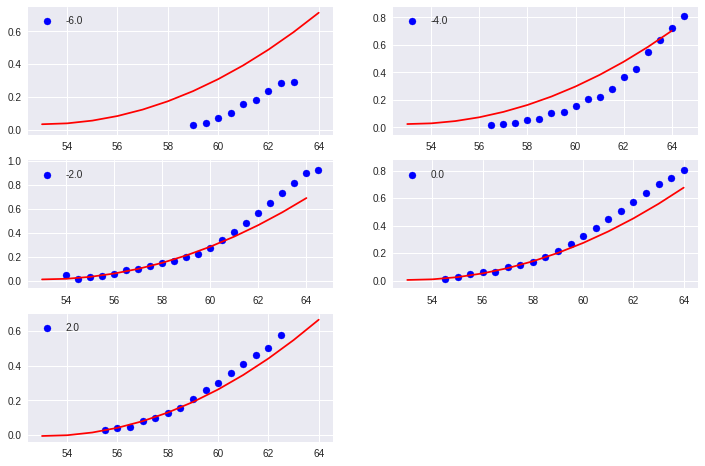

In [9]:
normMLTList = potDF["normMLT"].unique()[1::2]
selAsy = 0.


f = plt.figure(figsize=(12, 8))
ax = []
ax.append( f.add_subplot(3,2,1) )
ax.append( f.add_subplot(3,2,2) )
ax.append( f.add_subplot(3,2,3) )
ax.append( f.add_subplot(3,2,4) )
ax.append( f.add_subplot(3,2,5) )

for mind, currMLT in enumerate(normMLTList):
    subDF1 = mlatMLTPotDF[ (mlatMLTPotDF["normMLT"] == currMLT)&\
                              (mlatMLTPotDF["AsyHRnd"] == selAsy) ]
    subDF2a = predMlatMLTPotDF[ (predMlatMLTPotDF["predNormMlt"] == currMLT) &\
                              (predMlatMLTPotDF["predAsy"] == selAsy) ]
    
    ax[mind].scatter( subDF1["MLAT"].values, subDF1["normPot"].values, c="b", label=str(currMLT) )
    ax[mind].plot( subDF2a["predMLAT"].values, subDF2a["predPot"].values, c="r")
    ax[mind].legend()

[ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9]


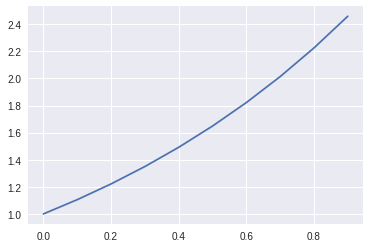

In [8]:
x = numpy.arange(0,1,0.1)
y = numpy.exp(x)
print x
plt.plot(x,y)